# M1 coursework

Notifcation: Generation tools such as ChatGPT and Claude.ai were used to faciliate the code development in this section. Such tools are used for debugging code in the following sections: 1. combining the MNIST images 2. saving the MNIST best model into a .keras file 3. indexing the concatenated images and their respective individual digits 4. splitting the test images for the sequential linear classifier 5. debugging the t-SNE plots. It was also used to facilitate the generation of barcharts, confusion matrixes and line plots, requirements.txt and dockerfile.

### Question 1: Loading in the data

First I will load in all my packages

In [2]:
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist #to import our dataset
from tensorflow.keras.models import Sequential, Model # imports our type of network
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout # imports our layers we want to use

from tensorflow.python.keras.losses import categorical_crossentropy #loss function
from tensorflow.keras.optimizers import Adam, SGD #optimisers
from tensorflow.keras.utils import to_categorical #some function for data preparation
import optuna
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Ensure this is included
from tensorflow.keras.models import load_model

import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sns


2024-12-18 16:21:22.748635: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Jasthecoolbean/Desktop/cw/M1/jn492/m1venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Loading the dataset

First I set a global seed to ensure reproducibility. I then loaded in the mnist data set, combined them to make them side by side, and then sampled randomly from it 60,000 combined images. 

In [4]:
rng = np.random.default_rng(2304)
from sklearn.model_selection import train_test_split

# Load MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize data
x_train_full = x_train_full / 255.0
x_test = x_test / 255.0

# Split training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=2304)

# Function to combine images and create labels, including original indices
def combine_images_and_labels_with_indices(x_data, y_data, num_pairs): 
    combined_images = []
    combined_labels = []
    left_indices = []  # To store the indices of the left images
    right_indices = []  # To store the indices of the right images
    
    for _ in range(num_pairs):
        # Randomly select two indices
        idx1, idx2 = rng.choice(len(x_data), size=2, replace=False)#randomly select two indices along the length of the image set. do not select the same two indices.
        
        # Combine images horizontally
        combined_image = np.hstack((x_data[idx1], x_data[idx2])) #combine the images horizontally
        
        # Sum the labels
        combined_label = y_data[idx1] + y_data[idx2] #sum the labels for that indices
        
        # Append to the lists
        combined_images.append(combined_image)
        combined_labels.append(combined_label)
        left_indices.append(idx1)  # Save the left index
        right_indices.append(idx2)  # Save the right index
    
    return np.array(combined_images), np.array(combined_labels), np.array(left_indices), np.array(right_indices)

# Generate training, validation, and test sets with indices
train_images, train_labels, train_left_indices, train_right_indices = combine_images_and_labels_with_indices(x_train, y_train, num_pairs=50000)
val_images, val_labels, val_left_indices, val_right_indices = combine_images_and_labels_with_indices(x_val, y_val, num_pairs=10000)
test_images, test_labels, test_left_indices, test_right_indices = combine_images_and_labels_with_indices(x_test, y_test, num_pairs=10000)

# Print the shapes of the new datasets
print("Training combined set shape:", train_images.shape, train_labels.shape)
print("Validation combined set shape:", val_images.shape, val_labels.shape)
print("Test combined set shape:", test_images.shape, test_labels.shape)
print("Training left and right indices shapes:", train_left_indices.shape, train_right_indices.shape)

Training combined set shape: (50000, 28, 56) (50000,)
Validation combined set shape: (10000, 28, 56) (10000,)
Test combined set shape: (10000, 28, 56) (10000,)
Training left and right indices shapes: (50000,) (50000,)


let's print the training test set to see it's shape.

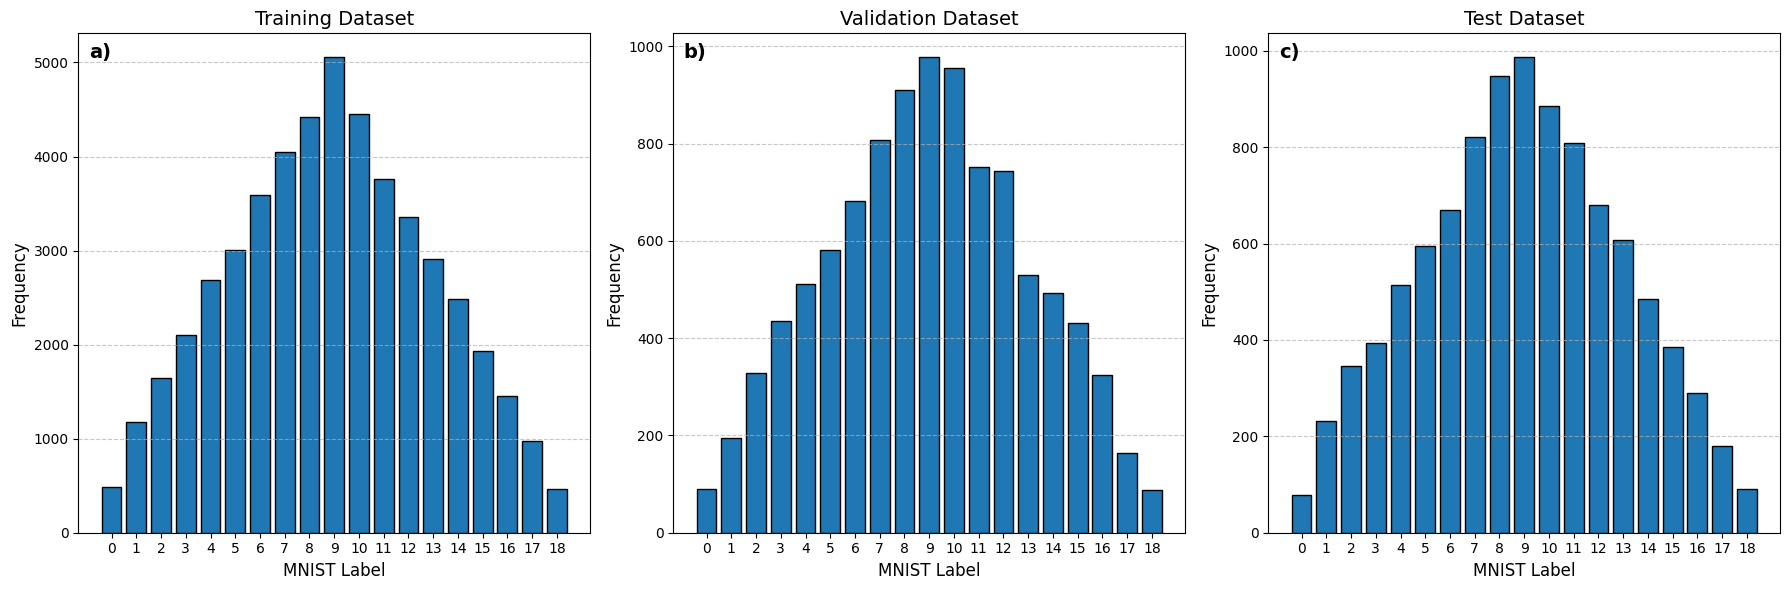

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_labels, val_labels, and test_labels are already defined

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the training dataset histogram
axes[0].hist(train_labels, bins=np.arange(-0.5, 19.5, 1), align='mid', rwidth=0.8, edgecolor='black')
axes[0].set_title("Training Dataset", fontsize=14)
axes[0].set_xlabel("MNIST Label", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)
axes[0].set_xticks(range(0, 19))  # Labels range from 0 to 18
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].annotate("a)", xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, weight='bold')

# Plot the validation dataset histogram
axes[1].hist(val_labels, bins=np.arange(-0.5, 19.5, 1), align='mid', rwidth=0.8, edgecolor='black')
axes[1].set_title("Validation Dataset", fontsize=14)
axes[1].set_xlabel("MNIST Label", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].set_xticks(range(0, 19))  # Labels range from 0 to 18
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].annotate("b)", xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, weight='bold')

# Plot the test dataset histogram
axes[2].hist(test_labels, bins=np.arange(-0.5, 19.5, 1), align='mid', rwidth=0.8, edgecolor='black')
axes[2].set_title("Test Dataset", fontsize=14)
axes[2].set_xlabel("MNIST Label", fontsize=12)
axes[2].set_ylabel("Frequency", fontsize=12)
axes[2].set_xticks(range(0, 19))  # Labels range from 0 to 18
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
axes[2].annotate("c)", xy=(0.02, 0.95), xycoords='axes fraction', fontsize=14, weight='bold')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()



Now I will make some test data set, and make them into one_hot labels so they can be used for testing.

In [5]:
# convert class vectors to binary class matrices
onehot_val=to_categorical(val_labels, 19)
onehot_train = to_categorical(train_labels, 19) # Converts these integer labels into one-hot encoded vectors. ie for three it is [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
onehot_test = to_categorical(test_labels, 19)

A combined image will look something like this:

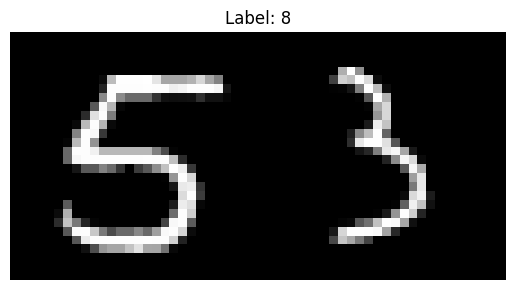

In [5]:
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.axis('off')
plt.show()

## Question 2: Fully connected neural network 

Now I will try to find the best hyperparameters using optuna for my neural network. The below function will help me 

1. Set up an objective function that sets up the parameter space, the model
2. Use .optimize to maximize the validation accuracy in the function 
3. print the best model parameters, and save the best model to keras under optuna_NN

In [6]:
import joblib

def objective(trial):
    # Hyperparameter suggestions
    num_layers = trial.suggest_int('num_layers', 1, 3)
    batch_size = trial.suggest_int('batch_size', 16, 64, step=16)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    units = trial.suggest_int('units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    checkpoint_path = "best_NN_model.keras"
    checkpoint = ModelCheckpoint(
        checkpoint_path, 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max'
    )
    # Build the model
    model = Sequential()
    model.add(Input(shape=(28, 56)))  # Define input shape here
    model.add(Flatten())              # Flatten the input
    for _ in range(num_layers):
        model.add(Dense(units, activation='relu'))  # Fixed relu activation
        model.add(Dropout(dropout_rate))
    model.add(Dense(19, activation='softmax'))  # Output layer for 19 classes (sums 0-18)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_accuracy',  # Monitor validation accuracy
        patience=5,              # Stop if no improvement for 5 consecutive epochs
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Train the model
    history = model.fit(
        train_images,
        onehot_train,
        validation_data=(val_images, onehot_val),
        epochs=15,
        batch_size=batch_size,  # Include batch_size from trial
        verbose=1,
        callbacks=[checkpoint, early_stopping]  # Include ModelCheckpoint and EarlyStopping
    )

    # Return the best validation accuracy
    return max(history.history['val_accuracy'])


In [7]:
sampler = TPESampler(seed=2304)

### Note: 

The code below begins the optuna hyperparameter optimisation, and will take around 1.5 hours to run. For reproducibility, I have noted down the best parameters found, and will use those for testing. Also, the best model weights is saved to the file 'best_NN_model.keras', which can be used in later sections.

In [ ]:
# Create a study and optimize the objective function

study_nn = optuna.create_study(direction='maximize',sampler=sampler)  # Maximize validation accuracy# Make the sampler behave in a deterministic way.
study_nn.optimize(objective,n_trials=30)

# Print the best trial
print('Best trial:')
print(f'  Validation Accuracy: {study_nn.best_trial.value}')
print('  Hyperparameters:') #PRINTS THE BEST HYPERPARAMETERS
for key, value in study_nn.best_trial.params.items():
    print(f'    {key}: {value}')

## Best trial:
Validation Accuracy: 0.8895000219345093

Hyperparameters:\
num_layers: 3\
batch_size: 64\
dropout_rate: 0.05533067285284869\
units: 96\
learning_rate: 0.001263245646073991

To view the history of training and validation accuracy for the best model, I will use the best parameters and train a best model, then record the history:

In [9]:
# Best hyperparameters
# Use the best hyperparameters in your model
num_layers = 3
units = 96
dropout_rate = 0.0553
learning_rate = 0.00127
batch_size = 64

checkpoint_path = 'best_NN.keras'
checkpoint = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max'
)

# Build the model
best_NN = Sequential()
best_NN.add(Input(shape=(28, 56)))
best_NN.add(Flatten())
for _ in range(num_layers):
    best_NN.add(Dense(units, activation='relu'))
    best_NN.add(Dropout(dropout_rate))
best_NN.add(Dense(19, activation='softmax'))  # 19 classes (sums 0-18)

# Compile the model
best_NN.compile(optimizer=Adam(learning_rate=learning_rate),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,              # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore the best weights
)

# Retrain the model with early stopping and save the best version
best_NN_history = best_NN.fit(
    train_images,
    onehot_train,
    validation_data=(val_images, onehot_val),
    epochs=50,  # Maximum epochs
    batch_size=batch_size,
    verbose=1,
    callbacks=[early_stopping, checkpoint]  # Add the checkpoint callback
)

import pickle 

#27 epochs accuracy: 0.9502 - loss: 0.1605 - val_accuracy: 0.8901 - val_loss: 0.4844

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.2753 - loss: 2.1763 - val_accuracy: 0.7051 - val_loss: 0.9727
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7063 - loss: 0.9400 - val_accuracy: 0.7930 - val_loss: 0.7151
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.7890 - loss: 0.6923 - val_accuracy: 0.8206 - val_loss: 0.6304
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8254 - loss: 0.5765 - val_accuracy: 0.8420 - val_loss: 0.5647
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8529 - loss: 0.4930 - val_accuracy: 0.8523 - val_loss: 0.5298
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8702 - loss: 0.4326 - val_accuracy: 0.8618 - val_loss: 0.4986
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8848 - loss: 0.3841 - val_accuracy: 0.8684 - val_loss: 0.4887
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8938 - loss: 0.3522 - val_acc

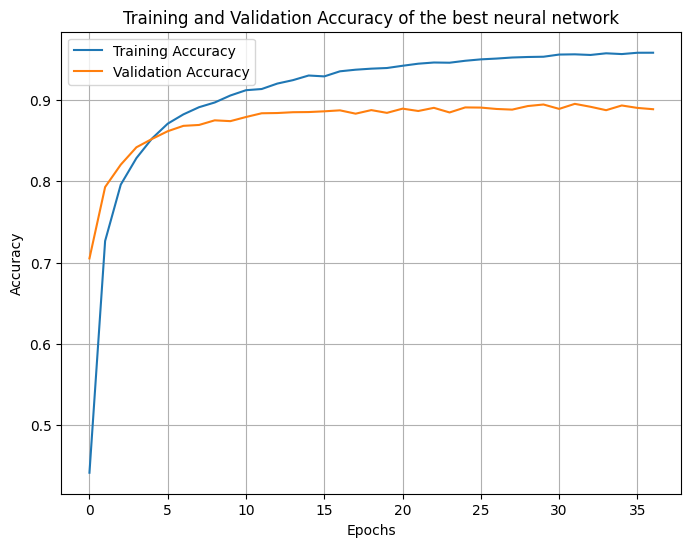

In [11]:

plt.figure(figsize=(8, 6))
plt.plot(best_NN_history.history['accuracy'], label='Training Accuracy')
plt.plot(best_NN_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy of the best neural network')
plt.legend()
plt.grid(True)
plt.show()

Test accuracy of the Best model:

In [6]:
the_best_model=load_model("best_NN.keras")
test_loss, test_accuracy = the_best_model.evaluate(test_images, onehot_test, verbose=0)

print(f"Best Model Test Accuracy: {test_accuracy}")

Best Model Test Accuracy: 0.9027000069618225


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


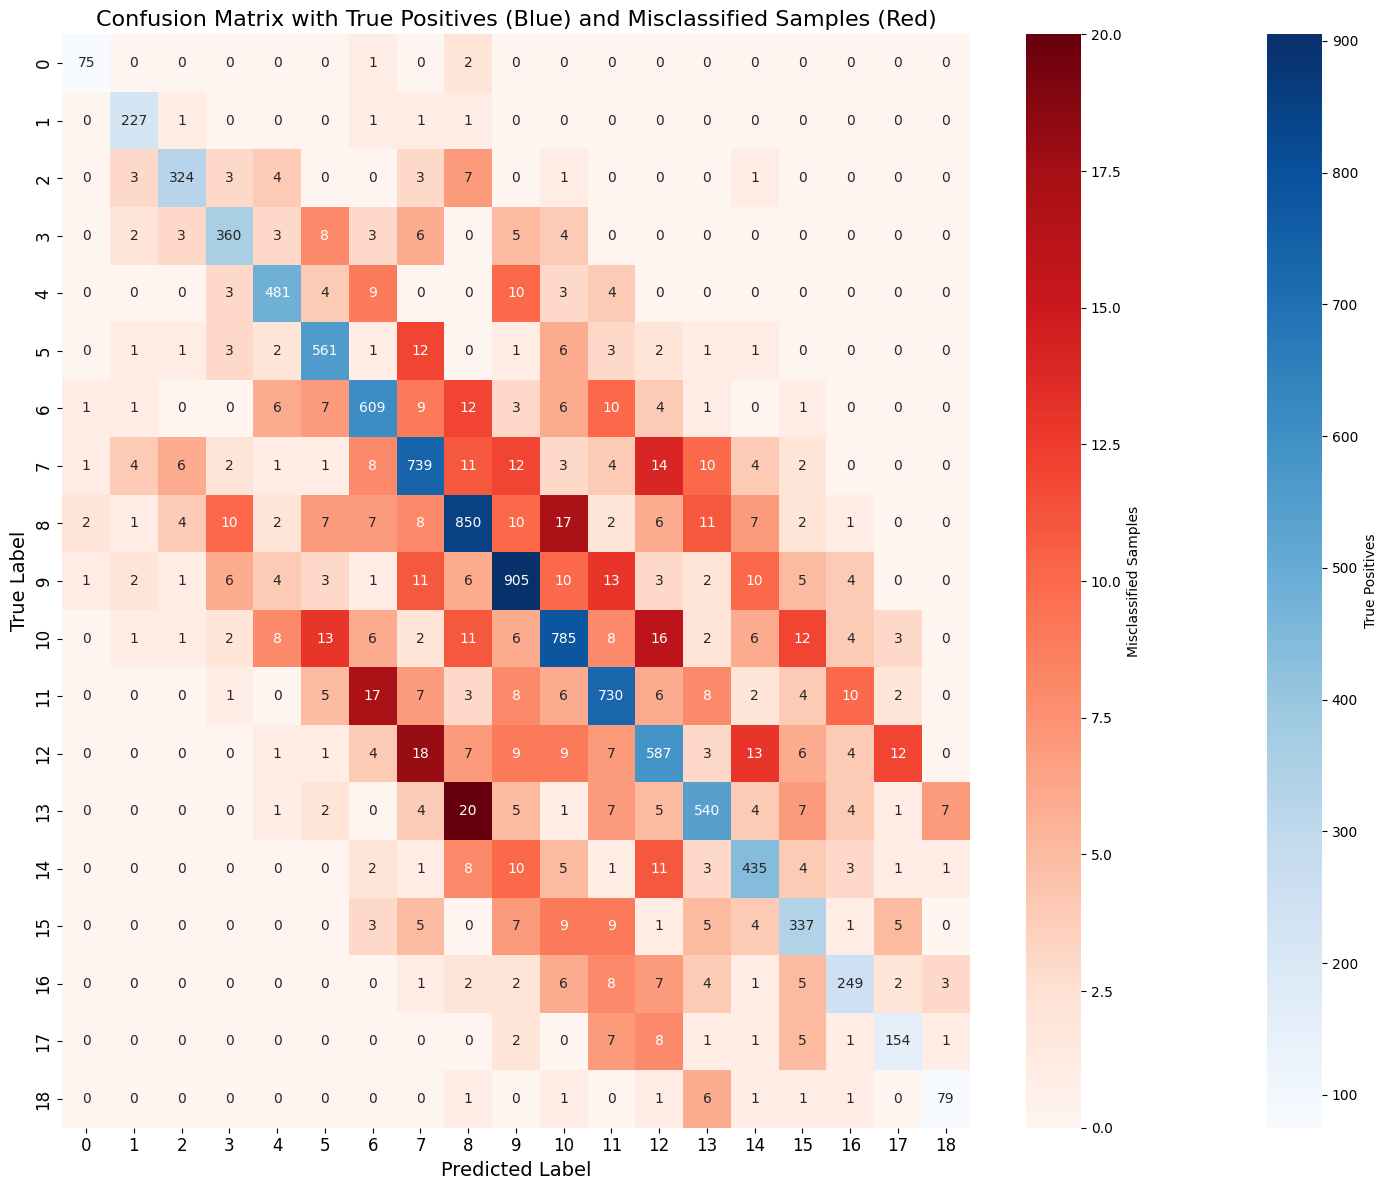

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict on the test dataset
predictions = the_best_model.predict(test_images)

# Convert predictions and true labels to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(onehot_test, axis=1)

cm = confusion_matrix(true_classes, predicted_classes)

# Create the plot
plt.figure(figsize=(15, 12))

# Create a mask for true positives (diagonal)
tp_mask = np.eye(cm.shape[0], dtype=bool)

# Create a mask for misclassifications (off-diagonal)
misclass_mask = ~tp_mask

# Plot true positives in blue with annotations
# Use np.where to modify the matrix for annotation
tp_annot = np.where(tp_mask, cm, np.nan)

sns.heatmap(cm, mask=misclass_mask, cmap="Blues", 
            annot=tp_annot, fmt=".0f", cbar=True, 
            cbar_kws={"label": "True Positives"}, 
            xticklabels=range(cm.shape[1]), 
            yticklabels=range(cm.shape[0]))

# Overlay misclassifications in red
sns.heatmap(cm, mask=tp_mask, cmap="Reds", annot=True, fmt=".0f", cbar=True, 
            cbar_kws={"label": "Misclassified Samples"}, 
            xticklabels=range(cm.shape[1]), 
            yticklabels=range(cm.shape[0]))

# Customize the plot
plt.title("Confusion Matrix with True Positives (Blue) and Misclassified Samples (Red)", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## Question 3: Testing other inference methods

Now I will try to find the best hyperparameters using optuna for other inference methods, and train the model with those parameters. The inference methods I will look into include: 

1. Support Vector Machine (SVM)
2. Random Forest 
3. Decision tree

### Support Vector Machine

1. Finding best parameters for SVM

In [16]:
from sklearn.svm import SVC
from tqdm import tqdm

In [17]:
# Flatten the image data
num_samples = train_images.shape[0]
train_images_flat = train_images.reshape(num_samples, -1)

num_samples_val = val_images.shape[0]
val_images_flat = val_images.reshape(num_samples_val, -1)

num_samples_test = test_images.shape[0]
test_images_flat = test_images.reshape(num_samples_test, -1)

In [18]:
# Sample 10% of the data for faster trials
train_images_subset, _, train_labels_subset, _ = train_test_split(
    train_images_flat, train_labels, test_size=0.9, random_state=2304
)
val_images_subset, _, val_labels_subset, _ = train_test_split(
    val_images_flat, val_labels, test_size=0.9, random_state=2304
)

test_images_subset, _, test_labels_subset, _ = train_test_split(
    test_images_flat, test_labels, test_size=0.9, random_state=2304
)

In [ ]:
# Define the range of gamma values with logarithmic spacing
gamma_values = np.logspace(-4, 0, num=10)  # 20 values from 10^-4 (0.0001) to 10^0 (1)

# Initialize an array to store scores
svm_scores = np.zeros(len(gamma_values))

# Loop through gamma values
for idx, gamma in enumerate(tqdm(gamma_values, desc="Training SVM", unit="Gamma")):
    svcClass = SVC(gamma=gamma)
    svcClass.fit(train_images_subset, train_labels_subset)
    svm_scores[idx] = svcClass.score(val_images_subset, val_labels_subset)  # Store the score for each gamma

In [ ]:
import pickle
with open('svm_gamma_scores.pkl', 'rb') as f:
    gamma_scores = pickle.load(f)

# Plot the results
plt.plot(gamma_values, gamma_scores,"o",color="black",linestyle="-")
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel("Gamma")
plt.ylabel("Validation Accuracy")
plt.title("SVM Validation Accuracy vs Gamma")
plt.show()

print("The highest Validation accuracy score at around 0.5 is when Gamma = 1.66810054e-02")

2. Using the best parameters for SVM for training the model. Then use .predict and .score to evaluate it against the test data.

In [7]:
from sklearn.svm import SVC
from joblib import dump, load

Due to limited computational resources (I apologise, my computer was really struggling to run this for ), I am unable to run svm on the full dataset. I can only run it for 

In [ ]:
best_svc = SVC(gamma=0.0166810054) 
best_svc.fit(train_images_flat, train_labels) 

#this took 1 hour and 13 minutes

In [9]:

svc_model=load('fitted_svc_model.joblib')



In [ ]:

svcPred = svc_model.predict(test_images_flat)
print('Test score: ', svcPred.score(test_images_flat, test_labels))


#Test score: 0.8152

In [ ]:
svc_values=load('svcPred_values.joblib')
print('Test score: ', svc_values.score(test_images_flat, test_labels))

### Random Forest

1. Find the best parameters for random forest (for svm i used a subset because it took way too long. here i just used the full set of 50,000, but flattened)

In [22]:
depth_range = np.linspace(1,25,10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define a range of max_depth values

scores = []

# Loop over depths
for max_depth in (tqdm(depth_range, desc="Training random forest",unit="depth")):
    RFClass = RandomForestClassifier(max_depth=max_depth, random_state=42)
    RFClass.fit(train_images_flat, train_labels) 
    score = RFClass.score(val_images_flat, val_labels)  # Use a validation set for scoring
    scores.append(score)


In [ ]:
with open('rf_scores.pkl', 'rb') as f:
    randf_scores = pickle.load(f)
    
# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(depth_range, randf_scores, marker='o',color="black")
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Random Forest Validation Accuracy vs Maximum Depth of Tree")
plt.grid()
plt.show()

# Find the optimal max_depth
optimal_depth = depth_range[np.argmax(randf_scores)]
print(f"Optimal max_depth: {optimal_depth}, Validation Accuracy: {max(randf_scores):.4f}")

2. Using the best parameters to train my model and evlauate it against the test data

In [ ]:
bestrf = RandomForestClassifier(
    max_depth=22,
    random_state=42### change
)
bestrf.fit(train_images_flat, train_labels) 
bestrf_Pred = bestrf.predict(test_images_flat)

print('Test score: ', bestrf.score(test_images_flat, test_labels))

#Test score:  0.7389

### Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define a range of max_depth values
depth_range = np.linspace(1,25,10, dtype=int)
tree_scores = []

# Loop over depths
for max_depth in (tqdm(depth_range, desc="Training decision tree", unit="depth")):
    DecTreeClass = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DecTreeClass.fit(train_images_flat, train_labels) 
    dectreescores = DecTreeClass.score(val_images_flat, val_labels)  # Use a validation set for scoring
    tree_scores.append(dectreescores)

In [ ]:
with open('decision_tree_scores.pkl', 'rb') as f:
    dtscores = pickle.load(f)
    
# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(depth_range, dtscores, marker='o',color="black")
plt.xlabel("Max Depth")
plt.ylabel("Validation Accuracy")
plt.title("Decision tree Validation Accuracy vs Max Depth")
plt.grid()
plt.show()

# Find the optimal max_depth
optimal_depth = depth_range[np.argmax(dtscores)]
print(f"Optimal max_depth: {optimal_depth}, Validation Accuracy: {max(dtscores):.4f}")

In [ ]:
bestdtc = DecisionTreeClassifier(
    max_depth=14,
    random_state=42
)
bestdtc.fit(train_images_flat, train_labels) 
bestdtc_Pred = bestdtc.predict(test_images_flat)

print('Test score: ', bestdtc.score(test_images_flat, test_labels))

#Test score:  0.46

combined code to show all the hyper parameter tuning plots side by side 

In [ ]:
 # Create a figure with three subplots arranged in a single row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: SVM Validation Accuracy vs Gamma
axes[0].plot(gamma_values, gamma_scores, "o-", color="black")
axes[0].set_xscale('log')  # Set x-axis to logarithmic scale
axes[0].set_xlabel("Gamma")
axes[0].set_ylabel("Validation Accuracy")
axes[0].set_title("SVM Validation Accuracy vs Gamma")
axes[0].grid()

# Subplot 2: Random Forest Validation Accuracy vs Max Depth
axes[1].plot(depth_range, randf_scores, marker='o', color="black")
axes[1].set_xlabel("Max Depth")
axes[1].set_ylabel("Validation Accuracy")
axes[1].set_title("Random Forest Validation Accuracy vs Max Depth")
axes[1].grid()

# Subplot 3: Decision Tree Validation Accuracy vs Max Depth
axes[2].plot(depth_range, dtscores, marker='o', color="black")
axes[2].set_xlabel("Max Depth")
axes[2].set_ylabel("Validation Accuracy")
axes[2].set_title("Decision Tree Validation Accuracy vs Max Depth")
axes[2].grid()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

combined code to show the test results for all the models

In [ ]:
import matplotlib.pyplot as plt

# Data for the bar plot
models = ['Neural Network', 'SVC', 'Random Forest', 'Decision Tree']
test_accuracies = [0.898, 0.8152, 0.739, 0.46]

# Color-blind friendly palette
colors = ['#0072B2', '#E69F00', '#009E73', '#D55E00']  # Blue, Orange, Green, Red

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, test_accuracies, color=colors)
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of Different Models')
plt.ylim(0, 1)  # Set the y-axis to range from 0 to 1 for clarity
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


## Question 4: Using Weak Linear Classifiers

1. Train a single classifier on the full dataset and evaluate its performance.
2. Train sequential classifiers on separate halves of the dataset and combine their results.
3. Compare their performance (e.g., probabilities, accuracy) across different training sample sizes (50, 100, 500, 1000).
4. Analyze how these methods perform on the test set and why one might be better than the other.

Again, I want to find what is the best number of estimators for this classifier.

In [9]:
# I am using logistic regression

from sklearn.linear_model import LogisticRegression

For the first part of the problem, I try to use logistic regression for my entire dataset all at once. Logistic regression has hyperparameters such as C, which dicatates the regularization. Smaller values of C will lead to more regularization, preventing overfitting. I will try to use lambda=1, and hence C=1.

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Your sample sizes
sample_size = [50, 100, 500, 1000]

# Placeholder to store results
results = {}

# Initialize the logistic regression model
logreg = LogisticRegression(max_iter=1000) #100 failed to converge so i am trying 1000

# Loop through each sample size
for size in tqdm(sample_size, desc="training logistic regression", unit="sample size"):
    # Randomly sample indices for the training data
    indices = np.random.choice(len(train_images_flat), size, replace=False)
    
    # Create subsets for training
    sampled_train_images = train_images_flat[indices]
    sampled_train_labels = train_labels[indices]
    
    # Fit logistic regression on the sampled data
    logreg.fit(sampled_train_images, sampled_train_labels)
    
    # Check accuracy on the test set
    test_accuracy = logreg.score(test_images_flat, test_labels)
    
    # Store the results
    results[size] = test_accuracy
    print(f"Sample Size: {size}, Test Accuracy: {test_accuracy:.4f}")

# Print summary of results
print("\nSummary of Results:")
for size, accuracy in results.items():
    print(f"Sample Size: {size}, Test Accuracy: {accuracy:.4f}")


I want to sample from the combined dataset (the horizontally combined images), keep track of their original indices, and use those indices to retrieve the original MNIST labels. Then, train logistic regressions using the original MNIST labels (separately for the left and right parts), predict the outputs using .predict, and finally sum the predicted outputs to compare with the true summed labels of the combined dataset.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

np.random.seed(2304)
tf.random.set_seed(2304)

# Define sample sizes
sample_sizes = [50, 100, 500, 1000]

# Initialize dictionary to store results
results = {}

# Loop through each sample size
for sample_size in sample_sizes:
    print(f"\nTraining with sample size: {sample_size}")

    # Step 1: Randomly sample indices from the combined training images
    sampled_indices = np.random.choice(len(train_images), size=sample_size, replace=False)

    # Step 2: Extract the sampled combined images and their corresponding summed labels
    sampled_combined_images = train_images[sampled_indices]
    sampled_combined_labels = train_labels[sampled_indices]  # The summed labels of the combined images

    # Step 3: Retrieve the original indices for the left and right images
    sampled_left_indices = train_left_indices[sampled_indices]
    sampled_right_indices = train_right_indices[sampled_indices]

    # Step 4: Retrieve the original MNIST labels for the left and right parts
    L_train_labels = y_train[sampled_left_indices]  # Original labels for the left images
    R_train_labels = y_train[sampled_right_indices]  # Original labels for the right images

    # Step 5: Retrieve the original MNIST images for the left and right parts
    L_train_images = x_train[sampled_left_indices].reshape(sample_size, -1)  # Flatten left images
    R_train_images = x_train[sampled_right_indices].reshape(sample_size, -1)  # Flatten right images

    # Step 6: Train logistic regression models for the left and right parts
    L_model = LogisticRegression(max_iter=1000, random_state=2304)  # Model for left images
    R_model = LogisticRegression(max_iter=1000, random_state=2304)  # Model for right images

    L_model.fit(L_train_images, L_train_labels)  # Train the left model
    R_model.fit(R_train_images, R_train_labels)  # Train the right model

    # Step 10: Evaluate the model on the test data
    # Retrieve the original MNIST test images for the left and right parts
    L_test_images = x_test[test_left_indices].reshape(len(test_left_indices), -1)  # Flatten left test images
    R_test_images = x_test[test_right_indices].reshape(len(test_right_indices), -1)  # Flatten right test images

    # Predict outputs for the test data
    L_test_preds = L_model.predict(L_test_images)  # Predictions for left test images
    R_test_preds = R_model.predict(R_test_images)  # Predictions for right test images

    # Combine predictions for the test data
    combined_test_preds = L_test_preds + R_test_preds

    # Compare the combined test predictions to the actual test combined labels using accuracy score
    test_accuracy = accuracy_score(test_labels, combined_test_preds)
    print(f"Test Accuracy: {test_accuracy}")

    # Store the results for the current sample size
    results[sample_size] = {
        "test_accuracy": test_accuracy
    }

# Step 11: Print final results
print("\nFinal Results:")
for size, metrics in results.items():
    print(f"Sample Size {size}, Test Accuracy: {metrics['test_accuracy']}")



Below, I am plotting the probability outcomes for each classifier, using a test example image

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression

# Placeholder to store results
results = {}

# Initialize the logistic regression model
logreg50 = LogisticRegression(max_iter=1000)

# Sample size 50
indices = np.random.choice(len(train_images_flat), size=1000, replace=False)
sampled_train_images = train_images_flat[indices]
sampled_train_labels = train_labels[indices]

# Train the model
logreg50.fit(sampled_train_images, sampled_train_labels)

# Predict probabilities for the first test image (reshaped to (1, 1568))
first_image_probs = logreg50.predict_proba(test_images_flat[0, :].reshape(1, -1))

# Output the probabilities
print("Predicted probabilities for the first image:")
print(first_image_probs)


In [ ]:

# Step 2: Extract the sampled combined images and their corresponding summed labels
sampled_combined_images = train_images[indices]
sampled_combined_labels = train_labels[indices]  # The summed labels of the combined images

# Step 3: Retrieve the original indices for the left and right images
sampled_left_indices = train_left_indices[indices]
sampled_right_indices = train_right_indices[indices]

# Step 4: Retrieve the original MNIST labels for the left and right parts
L_train_labels = y_train[sampled_left_indices]  # Original labels for the left images
R_train_labels = y_train[sampled_right_indices]  # Original labels for the right images

# Step 5: Retrieve the original MNIST images for the left and right parts
L_train_images = x_train[sampled_left_indices].reshape(1000, -1)  # Flatten left images
R_train_images = x_train[sampled_right_indices].reshape(1000, -1)  # Flatten right images

# Step 6: Train logistic regression models for the left and right parts
L_model = LogisticRegression(max_iter=1000, random_state=2304)  # Model for left images
R_model = LogisticRegression(max_iter=1000, random_state=2304)  # Model for right images

L_model.fit(L_train_images, L_train_labels)  # Train the left model
R_model.fit(R_train_images, R_train_labels)  # Train the right model

# Extract the left and right parts of the first test image
L_test_image = x_test[test_left_indices[0]].reshape(1, -1)  # Flatten left part (1, 784)
R_test_image = x_test[test_right_indices[0]].reshape(1, -1)  # Flatten right part (1, 784)

# Predict probabilities for the left and right parts
first_image_probs_L = L_model.predict_proba(L_test_image)
first_image_probs_R = R_model.predict_proba(R_test_image)

# Print probabilities
print("Left model probabilities for the first test image:")
print(first_image_probs_L)
print("Right model probabilities for the first test image:")
print(first_image_probs_R)


In [ ]:
# Extract and flatten probabilities (if needed)
combined_probs = first_image_probs.flatten()  # 0–18
left_probs = first_image_probs_L.flatten()    # 0–9
right_probs = first_image_probs_R.flatten()   # 0–9

# Define class labels
combined_classes = np.arange(len(combined_probs))  # 0–18
left_classes = np.arange(len(left_probs))          # 0–9
right_classes = np.arange(len(right_probs))        # 0–9

# Define color-blind friendly colors
colors = {
    "combined": "#377eb8",  # Blue
    "left": "#4daf4a",      # Green
    "right": "#ff7f00"      # Orange
}

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Plot combined probabilities
axes[0].bar(combined_classes, combined_probs, color=colors["combined"], edgecolor="black")
axes[0].set_title("Single linear classifier on concatenated MNIST number 9", fontsize=14)
axes[0].set_xlabel("MNIST digit", fontsize=12)
axes[0].set_ylabel("Probability", fontsize=12)
axes[0].set_xticks(combined_classes)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Plot left model probabilities
axes[1].bar(left_classes, left_probs, color=colors["left"], edgecolor="black")
axes[1].set_title("(Sequentual) Left linear classifier on single MNIST digit 3", fontsize=14)
axes[1].set_xlabel("MNIST digit", fontsize=12)
axes[1].set_xticks(left_classes)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Plot right model probabilities
axes[2].bar(right_classes, right_probs, color=colors["right"], edgecolor="black")
axes[2].set_title("(Sequentual) Left linear classifier on single MNIST digit 6", fontsize=14)
axes[2].set_xlabel("MNIST digit", fontsize=12)
axes[2].set_xticks(right_classes)
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [ ]:
plt.imshow(test_images[0, :, :], cmap='gray')
plt.title(f"Label: {test_labels[0]}")
plt.axis('off')
plt.show()

I want to also try plotting the confusion matrix and visualising the probabilities.

## Question 5: t-SNE

#### t-SNE distribution of classes in the embedding layer (before output)

First, to inspect my model and to see what my embedding layer is called:

In [ ]:
nn_model=load_model("final_NN.keras")
nn_model.summary()

In [ ]:


from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
import numpy as np

# Check if the shape of the training data is correct
if train_images.shape == (1, 50000, 28, 56):
    train_images = train_images[0]  # Remove the extra batch dimension

# Access the embedding layer inside the sequential model
embedding_layer_output = nn_model.get_layer("dense_98").output  # Replace with the correct name

# Create the embedding model using `inputs`
embedding_model = Model(inputs=nn_model.inputs, outputs=embedding_layer_output)

# Randomly sample 5,000 indices for efficiency
subset_indices = np.random.choice(len(train_images), size=5000, replace=False)

# Select the subset of images
subset_images = train_images[subset_indices]
subset_labels = train_labels[subset_indices]

# Generate embeddings for the subset
embedding_output = embedding_model.predict(subset_images)

In [7]:
from sklearn.manifold import TSNE


In [ ]:

# Define perplexity values
perplexities = [5, 30, 50, 100]

# Initialize figure
fig, axes = plt.subplots(1, len(perplexities), figsize=(20, 5))

# Apply t-SNE for each perplexity and plot
for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=2304)
    X_embedded = tsne.fit_transform(embedding_output)  # Use embeddings instead of raw images
    scatter = axes[i].scatter(X_embedded[:, 0], X_embedded[:, 1], c=subset_labels.astype(int), cmap='tab10', s=1)
    axes[i].set_title(f"Perplexity: {perplexity}")
    axes[i].set_xlabel("t-SNE Dim 1")
    axes[i].set_ylabel("t-SNE Dim 2")
    fig.colorbar(scatter, ax=axes[i], orientation='vertical', label='Classes')

# Adjust layout and show plots
plt.tight_layout()
plt.show()


#### Now, how about my input layers? what do they look like with t-sne?

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Define perplexity values
perplexities = [5, 30, 50, 100]

# Define the number of samples to use
subset_size = 5000

# Initialize figure for subplots
fig, axes = plt.subplots(1, len(perplexities), figsize=(20, 5))

# Loop through each perplexity value and apply t-SNE
for i, perplexity in enumerate(perplexities):
    # Randomly sample a subset of data and labels
    subset_indices = np.random.choice(len(train_images_flat), size=subset_size, replace=False)
    subset_images = train_images_flat[subset_indices]  # Subset of the flattened images
    subset_labels = onehot_train[subset_indices]       # Subset of the one-hot encoded labels
    
    # Apply t-SNE on the subset of data
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=2304)
    X_embedded_inputs = tsne.fit_transform(subset_images)  # Apply t-SNE on the subset
    
    # Plot the results
    scatter = axes[i].scatter(
        X_embedded_inputs[:, 0], X_embedded_inputs[:, 1], 
        c=np.argmax(subset_labels, axis=1), cmap='tab10', s=5  # Convert one-hot labels to integers
    )
    axes[i].set_title(f"Perplexity: {perplexity}")
    axes[i].set_xlabel("t-SNE Dim 1")
    axes[i].set_ylabel("t-SNE Dim 2")
    fig.colorbar(scatter, ax=axes[i], orientation='vertical', label='Classes')

# Adjust layout and show plots
plt.tight_layout()
plt.show()
